# CS5665 Project | Titanic
**Tristan Thomas | A01866929**

First, import the data and packages.

In [336]:
 import numpy as np
 import pandas as pd

 from sklearn.preprocessing import StandardScaler
 from sklearn.model_selection import train_test_split
 from sklearn.linear_model import LogisticRegression
 from sklearn.metrics import accuracy_score

 train_data = pd.read_csv("train.csv")
#  train_data.head()

test_data = pd.read_csv("test.csv")
# test_data.head()

###Preprocessing / Classification

In [337]:
# get rid of duplicate data
train_data = train_data.drop_duplicates(keep=False)
test_data = test_data.drop_duplicates(keep=False)

# fill NaN values with median/mode
processed_train_data = train_data.copy()
processed_train_data["Age"].fillna(train_data["Age"].median(skipna=True), inplace=True)
processed_train_data["Embarked"].fillna(train_data['Embarked'].value_counts().idxmax(), inplace=True)
processed_test_data = test_data.copy()
processed_test_data["Age"].fillna(test_data["Age"].median(skipna=True), inplace=True)
processed_test_data["Embarked"].fillna(test_data['Embarked'].value_counts().idxmax(), inplace=True)
# for some reason the test data had 1 'Fare' with NaN value
processed_test_data["Fare"].fillna(test_data["Fare"].median(skipna=True), inplace=True)

# features - get rid of values that don't affect the outcome, or don't have enough data
features = processed_train_data.drop(['PassengerId','Survived','Name','Ticket','Cabin'],axis=1)
test_features = processed_test_data.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

# categorical variables
features = pd.get_dummies(features, columns=['Sex', 'Embarked'])
test_features = pd.get_dummies(test_features, columns=['Sex', 'Embarked'])

# label
y = processed_train_data['Survived']

# scale data
x_train = StandardScaler().fit_transform(features)

# used to evaluate model
x_train,x_test,y_train,y_test = train_test_split(x_train, y, test_size=0.25)

features.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


##Logistic Regression

Create and evaluate logistic regression model

In [338]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")

Test accuracy: 0.8116591928251121


###Predict (LR)

Run LR model with test data and create submission csv file.

In [339]:
# run LR model over test data and get list of survivors
survive_list = log_reg.predict(test_features)
id_list = test_data['PassengerId']

# create dictionary to store id list and survivor list
submission_dict = { 'PassengerId': id_list, 'Survived': survive_list}
# convert to pandas Data Frame
LR_submission_csv = pd.DataFrame(submission_dict)

# create submission csv file
LR_submission_csv.to_csv('LR_submission.csv', index=False)

###Kaggle Score: ~0.65

##Neural Network
Improve results by using a Neural Network model.

Split dev, train, and test for cross-validation purposes.

In [340]:
import torch

msk = np.random.randn(len(features)) < 0.8

training_features = torch.tensor(features[msk].values.astype('float32'))
dev_features = torch.tensor(features[~msk].values.astype('float32'))

training_labels = torch.tensor(y[msk].values)
dev_labels = torch.tensor(y[~msk].values)

test_features = torch.tensor(test_features.values.astype('float32'))

Create Neural Network as a class

In [341]:
from torch import nn

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.step1 = nn.Linear(10, 5)
        self.step2 = nn.Linear(5, 5)
        self.step3 = nn.Linear(5, 2)
        
    def forward(self, x):
        x = self.step1(x)
        x = nn.functional.relu(x)
        x = nn.functional.dropout(x, p=0.2)
        x = self.step2(x)
        x = nn.functional.relu(x)
        x = nn.functional.dropout(x, p=0.1)
        x = self.step3(x)
        x = nn.functional.log_softmax(x, dim=1)
        
        return x
    
net = Net()

Hyper Parameters

In [342]:
num_epochs = 500
learning_rate = 0.012

# using cross entropy loss and adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

###Train and Evaluate
Helper function for loss

In [343]:
def evaluate(net, test_features, test_labels=None, print_acc_and_cost = False, testing = False):
    with torch.no_grad():
        test_loss = 0
        log_preds = net(test_features)
        preds = torch.exp(log_preds)
        preds, survived = torch.max(preds, 1)
        if(testing):
            loss = criterion(log_preds,test_labels)
            equals = survived==test_labels.view(*survived.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            test_loss += loss.item()
            if(print_acc_and_cost):
                print(f'Testing accuracy : {accuracy*100:.3f}%')
                print(f'Testing Loss : {test_loss:.3f}')
            return test_loss
        else:
            return survived

Train and evaluate NN model

In [344]:
import matplotlib as mpl

steps = 0
training_losses,testing_losses = [],[]
for e in range(num_epochs):
    running_loss = 0
    optimizer.zero_grad()
    
    yhat = net(training_features)
    loss = criterion(yhat, training_labels)
    
    loss.backward()
    outputs = torch.exp(yhat)
    
    optimizer.step()
    steps += 1
    running_loss += loss.item()
    training_losses.append(running_loss)
    if(steps%50==0):
        with torch.no_grad():
            print(f'Epoch : {e+1}/{num_epochs}...')
            testing_losses.append(evaluate(net, dev_features, test_labels = dev_labels, print_acc_and_cost=True, testing = True))
        print(f'Training loss {running_loss:.3f}\n')
    else:
        with torch.no_grad():
            testing_losses.append(evaluate(net, dev_features, test_labels = dev_labels, print_acc_and_cost=False, testing = True))


Epoch : 50/500...
Testing accuracy : 69.756%
Testing Loss : 0.604
Training loss 0.620

Epoch : 100/500...
Testing accuracy : 72.195%
Testing Loss : 0.550
Training loss 0.538

Epoch : 150/500...
Testing accuracy : 78.537%
Testing Loss : 0.489
Training loss 0.492

Epoch : 200/500...
Testing accuracy : 82.927%
Testing Loss : 0.425
Training loss 0.488

Epoch : 250/500...
Testing accuracy : 80.000%
Testing Loss : 0.431
Training loss 0.461

Epoch : 300/500...
Testing accuracy : 79.512%
Testing Loss : 0.457
Training loss 0.449

Epoch : 350/500...
Testing accuracy : 80.488%
Testing Loss : 0.445
Training loss 0.462

Epoch : 400/500...
Testing accuracy : 82.927%
Testing Loss : 0.420
Training loss 0.449

Epoch : 450/500...
Testing accuracy : 82.439%
Testing Loss : 0.420
Training loss 0.452

Epoch : 500/500...
Testing accuracy : 82.927%
Testing Loss : 0.425
Training loss 0.441



Plot test/train loss

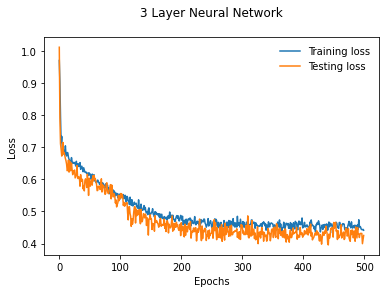

In [345]:
mpl.pyplot.plot(training_losses,label='Training loss')
mpl.pyplot.plot(testing_losses, label='Testing loss')
mpl.pyplot.xlabel("Epochs")
mpl.pyplot.ylabel("Loss")
mpl.pyplot.title("Test/Train Loss\n")
mpl.pyplot.legend(frameon = False)

###Predict (NN)
Run Net model with test data and create submission csv file.

In [346]:
# run NN model over test data and get list of survivors
survive_list = evaluate(net, test_features)
id_list = test_data['PassengerId']

# create dictionary to store id list and survivor list
submission_dict = { 'PassengerId': id_list, 'Survived': survive_list}
# convert to pandas Data Frame
NN_submission_csv = pd.DataFrame(submission_dict)

# create submission csv file
NN_submission_csv.to_csv('NN_submission.csv', index=False)

###Kaggle Score: ~0.78
